## Imports

In [46]:
import pandas as pd
import numpy as np
import re
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

## Read test and train datasets

In [15]:
train = pd.read_csv('../raw_data/fulltrain.csv', header=None)
test = pd.read_csv('../raw_data/balancedtest.csv', header=None)
train.columns=['Labels', 'News']
test.columns=['Labels', 'News']
print(train.head())
print(test.head())

   Labels                                               News
0       1  A little less than a decade ago, hockey fans w...
1       1  The writers of the HBO series The Sopranos too...
2       1  Despite claims from the TV news outlet to offe...
3       1  After receiving 'subpar' service and experienc...
4       1  After watching his beloved Seattle Mariners pr...
   Labels                                               News
0       1  When so many actors seem content to churn out ...
1       1   In what football insiders are calling an unex...
2       1  In a freak accident following Game 3 of the N....
3       1  North Koreas official news agency announced to...
4       1  The former Alaska Governor Sarah Palin would b...


3    17870
1    14047
4     9995
2     6942
Name: Labels, dtype: int64


<AxesSubplot:title={'center':'Distribution of train labels'}>

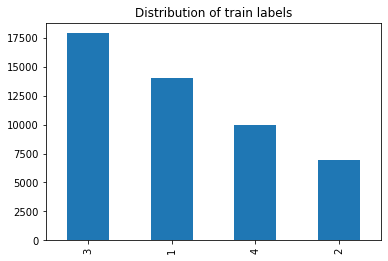

In [16]:
print(train['Labels'].value_counts())
train['Labels'].value_counts().plot(kind = 'bar', title = 'Distribution of train labels')
##Imbalanced dataset

1    750
2    750
3    750
4    750
Name: Labels, dtype: int64


<AxesSubplot:title={'center':'Distribution of test labels'}>

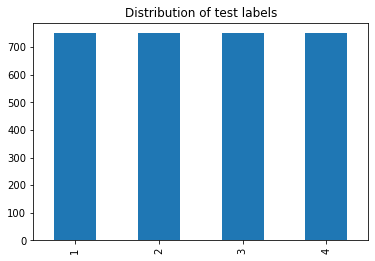

In [17]:
print(test['Labels'].value_counts())
test['Labels'].value_counts().plot(kind = 'bar', title = 'Distribution of test labels')

## Write simple preprocessor

In [18]:
##For some reason couldnt import the preprocessor from the other folder. Idk if it's a Jupiter notebook thing
import contractions
import string

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer

whitespace_tokenizer = WhitespaceTokenizer()

stopwords = list(stopwords.words('english'))


def preprocess_text(s, remove_stopwords=True, fix_contractions=True, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer, stemmer=None, lemmatizer=None, lowercase=True):
    # Throw error if both stemmer and lemmatizer are not None
    if stemmer is not None and lemmatizer is not None:
        raise ValueError("Stemmer and Lemmatizer cannot both be not None")

    # Tokenize with default tokenizer
    token_list = tokenizer.tokenize(s)

    # Fix contractions
    if fix_contractions:
        new_token_list = []
        for token in token_list:
            new_token = contractions.fix(token)
            if (len(new_token.split()) == 2):
                new_token_list.append(new_token.split()[0])
                new_token_list.append(new_token.split()[1])
            else:
                new_token_list.append(new_token)
        token_list = new_token_list

    # Stem or lemmatize if not None
    if stemmer is not None:
        for idx, token in enumerate(token_list):
            token_list[idx] = stemmer.stem(token)
    elif lemmatizer is not None:
        # Pos tagger to tag all tokens
        pos_tag_list = pos_tag(token_list)
        for idx, (token, tag) in enumerate(pos_tag_list):
            tag_simple = tag[0].lower()
            if tag_simple in ['n', 'v', 'j']:
                word_type = tag_simple.replace('j', 'a')
            else:
                word_type = 'n'
            lemmatized_token = lemmatizer.lemmatize(token, pos=word_type)
            token_list[idx] = lemmatized_token

    # Convert all tokens to lowercase if True
    if lowercase:
        token_list = [token.lower() for token in token_list]

    # Remove all stopwords if True
    if remove_stopwords:
        token_list = [token for token in token_list if not token in stopwords]

    # Remove all punctuation marks if True
    if remove_punctuation:
        token_list = [''.join(c for c in s if c not in string.punctuation) for s in token_list]
        token_list = [token for token in token_list if len(token) > 0]

    #return token_list
    return ' '.join(token_list)

## All permutations of preprocessing

In [21]:
x_train_stop = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=False, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_test_stop = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=False, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_train_con = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_test_con = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_train_punc = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=False, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_test_punc = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=False, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_train_stop_con = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_test_stop_con = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_train_stop_punc = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=False, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_test_stop_punc = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=False, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_train_con_punc = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_test_con_punc = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_train_stop_con_punc = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=True, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_test_stop_con_punc = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=True, fix_contractions=True, remove_punctuation=True,
                    tokenizer=whitespace_tokenizer))
x_train_none = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=False, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))
x_test_none = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=False, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer))

In [22]:
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
x_train_con_lemma = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer, lemmatizer=wordnet_lemmatizer))
x_train_con_stem = train['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer, stemmer=porter_stemmer))

In [27]:
x_test_con_lemma = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer, lemmatizer=wordnet_lemmatizer))
x_test_con_stem = test['News'].apply(lambda x : preprocess_text(x, remove_stopwords=False, fix_contractions=True, remove_punctuation=False,
                    tokenizer=whitespace_tokenizer, stemmer=porter_stemmer))

## Feature Engineering

In [31]:
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train['Labels'])
test_y = encoder.fit_transform(test['Labels'])


In [132]:
X_train = x_train_stop_con_punc
X_test = x_test_stop_con_punc

#### Count Vectorizer

In [133]:
count_vectorizer = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vectorizer.fit(X_train)
x_train_count = count_vectorizer.transform(X_train)
x_test_count = count_vectorizer.transform(X_test)

#### Tfidf Vectorizer - Char Ngram(1, 2)

In [ ]:
##Not feasible -- Too little information
tfidf_vectorizer_char = TfidfVectorizer(analyzer='char', ngram_range(1,2), max_features=10000)
tfidf_vectorizer_char.fit(X_train)
x_train_tfidf_char = tfidf_vectorizer_char.transform(X_train)
x_test_tfidf_char = tfidf_vectorizer_char.transform(X_test)

#### Tfidf Vectorizer - Word / Unigram

In [134]:
tfidf_vectorizer_word = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
tfidf_vectorizer_word.fit(X_train)
x_train_tfidf_word = tfidf_vectorizer_word.transform(X_train)
x_test_tfidf_word = tfidf_vectorizer_word.transform(X_test)

#### Tfidf Vectorizer - Unigrams and Bigrams

In [135]:
tfidf_vectorizer_ngram2 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,2), max_features=20000)
tfidf_vectorizer_ngram2.fit(X_train)
x_train_tfidf_ngram2 = tfidf_vectorizer_ngram2.transform(X_train)
x_test_tfidf_ngram2 = tfidf_vectorizer_ngram2.transform(X_test)

#### Tfidf Vectorizer - Unigrams and Bigrams and Trigrams

In [102]:
'''
##To try later if needed
tfidf_vectorizer_ngram3 = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,3), max_features=30000)
tfidf_vectorizer_ngram3.fit(X_train)
x_train_tfidf_ngram3 = tfidf_vectorizer_ngram3.transform(X_train)
x_test_tfidf_ngram3 = tfidf_vectorizer_ngram3.transform(X_test)
'''

"\n##To try later if needed\ntfidf_vectorizer_ngram3 = TfidfVectorizer(analyzer='word', token_pattern=r'\\w{1,}', ngram_range=(1,3), max_features=30000)\ntfidf_vectorizer_ngram3.fit(X_train)\nx_train_tfidf_ngram3 = tfidf_vectorizer_ngram3.transform(X_train)\nx_test_tfidf_ngram3 = tfidf_vectorizer_ngram3.transform(X_test)\n"

In [136]:
#Hyperparameter:
alpha_value=1

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def predict(model, X_valid):
    y_pred = model.predict(X_valid)
    return y_pred

In [137]:
naive_bayes_count_model = train_model(naive_bayes.MultinomialNB(alpha=alpha_value), x_train_count, train_y)
y_pred_nb_count = predict(naive_bayes_count_model, x_test_count)
nb_count_f1_score = metrics.f1_score(y_pred_nb_count, test_y, average='macro')
nb_count_accuracy_score = metrics.accuracy_score(y_pred_nb_count, test_y)
print("Count vectorizer f1_score is " + str(nb_count_f1_score))
print("Count vectorizer accuracy is " + str(nb_count_accuracy_score))

Count vectorizer f1_score is 0.6288138324436103
Count vectorizer accuracy is 0.6533333333333333


In [ ]:
'''
Count vectorizer f1 and accuracy scores:
No preprocessing:
Count vectorizer f1_score is 0.6648366966603887
Count vectorizer accuracy is 0.679
Contractions removed:
Count vectorizer f1_score is 0.6695618110202328
Count vectorizer accuracy is 0.6866666666666666
Stopwords removed:
Count vectorizer f1_score is 0.6677972020499174
Count vectorizer accuracy is 0.6806666666666666
Punctuation removed:
Count vectorizer f1_score is 0.6264366613111475
Count vectorizer accuracy is 0.6536666666666666
Stopwords and contractions removed:
Count vectorizer f1_score is 0.6669255857862734
Count vectorizer accuracy is 0.6823333333333333
Stopwords and punctuation removed:
Count vectorizer f1_score is 0.6261753209216978
Count vectorizer accuracy is 0.6506666666666666
Contractions and punctuation removed:
Count vectorizer f1_score is 0.6255990239756839
Count vectorizer accuracy is 0.6533333333333333
Stopwords, contractions and punctuation removed:
Count vectorizer f1_score is 0.6288138324436103
Count vectorizer accuracy is 0.6533333333333333
'''

In [138]:
naive_bayes_tfidf_word_model = train_model(naive_bayes.MultinomialNB(alpha=alpha_value), x_train_tfidf_word, train_y)
y_pred_nb_tfidf_word = predict(naive_bayes_tfidf_word_model, x_test_tfidf_word)
nb_tfidf_word_f1_score = metrics.f1_score(y_pred_nb_tfidf_word, test_y, average='macro')
nb_tfidf_word_accuracy_score = metrics.accuracy_score(y_pred_nb_tfidf_word, test_y)
print("Tfidf word f1_score is " + str(nb_tfidf_word_f1_score))
print("Tfidf word accuracy is " + str(nb_tfidf_word_accuracy_score))

Tfidf word f1_score is 0.6827353091503914
Tfidf word accuracy is 0.686


In [ ]:
'''
Tfidf word f1 and accuracy scores:
No preprocessing:
Tfidf word f1_score is 0.683878861491291
Tfidf word accuracy is 0.6873333333333334
Contractions removed:
Tfidf word f1_score is 0.6854522538517311
Tfidf word accuracy is 0.6906666666666667
Stopwords removed:
Tfidf word f1_score is 0.689722124862688
Tfidf word accuracy is 0.6923333333333334
Punctuation removed:
Tfidf word f1_score is 0.6776867759945222
Tfidf word accuracy is 0.683
Stopwords and contractions removed:
Tfidf word f1_score is 0.6891682040511752
Tfidf word accuracy is 0.693
Stopwords and punctuation removed:
Tfidf word f1_score is 0.6819728764781524
Tfidf word accuracy is 0.6853333333333333
Contractions and punctuation removed:
Tfidf word f1_score is 0.6781793402029098
Tfidf word accuracy is 0.683
Stopwords, contractions and punctuation removed:
Tfidf word f1_score is 0.6827353091503914
Tfidf word accuracy is 0.686
'''

In [139]:
naive_bayes_tfidf_ngram2_model = train_model(naive_bayes.MultinomialNB(alpha=alpha_value), x_train_tfidf_ngram2, train_y)
y_pred_nb_tfidf_ngram2 = predict(naive_bayes_tfidf_ngram2_model, x_test_tfidf_ngram2)
nb_tfidf_ngram2_f1_score = metrics.f1_score(y_pred_nb_tfidf_ngram2, test_y, average='macro')
nb_tfidf_ngram2_accuracy_score = metrics.accuracy_score(y_pred_nb_tfidf_ngram2, test_y)
print("Tfidf ngram2 f1_score is " + str(nb_tfidf_ngram2_f1_score))
print("Tfidf ngram2 accuracy is " + str(nb_tfidf_ngram2_accuracy_score))

Tfidf ngram2 f1_score is 0.6916478434781799
Tfidf ngram2 accuracy is 0.6936666666666667


In [ ]:
'''
Tfidf ngram2 f1 and accuracy scores:
No preprocessing:
20K
Tfidf ngram2 f1_score is 0.6904927036593713
Tfidf ngram2 accuracy is 0.695
Contractions removed(20K):
Tfidf ngram2 f1_score is 0.6957307273163922
Tfidf ngram2 accuracy is 0.703
Stopwords removed(20K):
Tfidf ngram2 f1_score is 0.6878052273096324
Tfidf ngram2 accuracy is 0.6893333333333334
Punctuation removed(20K):
Tfidf ngram2 f1_score is 0.6844410490110763
Tfidf ngram2 accuracy is 0.6913333333333334
Stopwords and contractions removed(20K):
Tfidf ngram2 f1_score is 0.7010536400814287
Tfidf ngram2 accuracy is 0.7036666666666667
Stopwords and punctuation removed(20K):
Tfidf ngram2 f1_score is 0.6891452524608814
Tfidf ngram2 accuracy is 0.691
Contractions and punctuation removed (20K):
Tfidf ngram2 f1_score is 0.6827694473244238
Tfidf ngram2 accuracy is 0.6896666666666667
Stopwords, contractions and punctuation removed (20K):
Tfidf ngram2 f1_score is 0.6916478434781799
Tfidf ngram2 accuracy is 0.6936666666666667
'''

In [ ]:
'''
30K
Tfidf ngram2 f1_score is 0.6942318664030661
Tfidf ngram2 accuracy is 0.6983333333333334
'''

In [74]:
'''
naive_bayes_tfidf_ngram3_model = train_model(naive_bayes.MultinomialNB(alpha=alpha_value), x_train_tfidf_ngram3, train_y)
y_pred_nb_tfidf_ngram3 = predict(naive_bayes_tfidf_ngram3_model, x_test_tfidf_ngram3)
nb_tfidf_ngram3_f1_score = metrics.f1_score(y_pred_nb_tfidf_ngram3, test_y, average='macro')
nb_tfidf_ngram3_accuracy_score = metrics.accuracy_score(y_pred_nb_tfidf_ngram3, test_y)
print("Tfidf ngram3 f1_score is " + str(nb_tfidf_ngram3_f1_score))
print("Tfidf ngram3 accuracy is " + str(nb_tfidf_ngram3_accuracy_score))
'''

Tfidf ngram3 f1_score is 0.680573686001227
Tfidf ngram3 accuracy is 0.6856666666666666


In [ ]:
## To be done if required
'''
Tfidf ngram3 f1 and accuracy scores:
No preprocessing:
10K
Tfidf ngram3 f1_score is 0.6599841938542438
Tfidf ngram3 accuracy is 0.6673333333333333
20K
Tfidf ngram3 f1_score is 0.680573686001227
Tfidf ngram3 accuracy is 0.6856666666666666
'''

In [66]:
naive_bayes_tfidf_char_model = train_model(naive_bayes.MultinomialNB(alpha=alpha_value), x_train_tfidf_char, train_y)
y_pred_nb_tfidf_char = predict(naive_bayes_tfidf_char_model, x_test_tfidf_char)
nb_tfidf_char_f1_score = metrics.f1_score(y_pred_nb_tfidf_char, test_y, average='macro')
nb_tfidf_char_accuracy_score = metrics.accuracy_score(y_pred_nb_tfidf_char, test_y)
print("Tfidf char f1_score is " + str(nb_tfidf_char_f1_score))
print("Tfidf char accuracy is " + str(nb_tfidf_char_accuracy_score))

Tfidf char f1_score is 0.09804052533018669
Tfidf char accuracy is 0.19533333333333333


In [ ]:
##Findings
##Tfidf char is not feasible since char contains too little information
##Best model looks to be tfidf vectorizer feature enginnering with unigram and bigram with stopwords and contractions removed.